In [1]:
from sde import * 

{('rain', 'grass wet'): 0.9, ('rain', 'sidewalk wet'): 0.75, ('rain', 'road wet'): 0.8, ('sprinkler', 'grass wet'): 0.8, ('sprinkler', 'sidewalk wet'): 0.7, ('water fountain', 'sidewalk wet'): 0.1, ('grass wet', 'grass healthy'): 0.8, ('sidewalk wet', 'person slipped'): 0.8, ('road wet', 'person slipped'): 0.3}


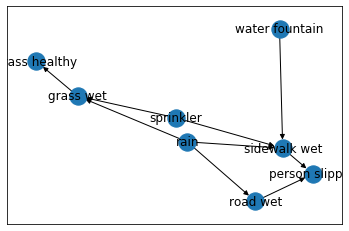

In [2]:
DG = nx.DiGraph() # creates directed graph
DG.add_node("rain")
DG.add_node("sprinkler")
DG.add_node("water fountain")
DG.add_node("grass wet")
DG.add_node("sidewalk wet")
DG.add_node("road wet")
DG.add_node("person slipped")
DG.add_node("grass healthy")

edge_list = [("rain", "grass wet", 0.9), ("rain", "sidewalk wet", 0.75), ("rain", "road wet", 0.8), ("sprinkler", "grass wet", 0.8), ("sprinkler", "sidewalk wet", 0.7), ("water fountain", "sidewalk wet", 0.1), ("sidewalk wet", "person slipped", 0.8), ("road wet", "person slipped", 0.3), ("grass wet", "grass healthy", 0.8)]
DG.add_weighted_edges_from(edge_list) # adds edges to graph

print(nx.get_edge_attributes(DG, 'weight'))

nx.draw_networkx(DG)

In [3]:
import operator

unsort_centDict = nx.degree_centrality(DG)    #get centrality values for each node in the graph 
centDict = dict(sorted(unsort_centDict.items(), key=operator.itemgetter(1),reverse=True))
print(centDict)

{'sidewalk wet': 0.5714285714285714, 'rain': 0.42857142857142855, 'grass wet': 0.42857142857142855, 'sprinkler': 0.2857142857142857, 'road wet': 0.2857142857142857, 'person slipped': 0.2857142857142857, 'water fountain': 0.14285714285714285, 'grass healthy': 0.14285714285714285}


In [4]:
def getHighestCentralityNodes(dg):
    nx.degree_centrality(dg)   #returns dict with items {node:centrality}
    highest_cent_nodes = []   #initiate list for highest centrality nodes
    centMax = max(centDict.values())    #find highest centrality in the graph

    highest_cent_nodes = [key_node for key_node in centDict if (centDict.get(key_node) == centMax)]  #list of nodes with highest key node value
    
    #if there is a singular highest centrality node, then add the second highest node(s) to the list
    while (len(highest_cent_nodes) < 2): 
        centDict2 = {key:val for key, val in centDict.items() if val != centMax}
        centMax2 = max(centDict2.values())
        secHighestNodes = [key_node for key_node in centDict2 if (centDict2.get(key_node) == centMax2)]
        highest_cent_nodes += secHighestNodes
        
    return highest_cent_nodes

centralNodes = getHighestCentralityNodes(DG)
print(centralNodes)

['sidewalk wet', 'rain', 'grass wet']


In [5]:
for node in centralNodes:
    print(node)
    print('Children:', get_all_children(DG, node, {}))
    print('Descendants:', get_descendants(DG, node, {}))
    print()

sidewalk wet
Children: {'person slipped': 0.8}
Descendants: {'person slipped': 0.8}

rain
Children: {'grass wet': 0.9, 'grass healthy': 0.7200000000000001, 'sidewalk wet': 0.75, 'person slipped': 0.24, 'road wet': 0.8}
Descendants: {'grass wet': 0.9, 'grass healthy': 0.7200000000000001, 'sidewalk wet': 0.75, 'person slipped': 0.24, 'road wet': 0.8}

grass wet
Children: {'grass healthy': 0.8}
Descendants: {'grass healthy': 0.8}



In [6]:
import itertools

# split list of highest cent nodes into all possible subsets size 2
HCNchoose2 = list(itertools.combinations(centralNodes, 2))
print(HCNchoose2)

[('sidewalk wet', 'rain'), ('sidewalk wet', 'grass wet'), ('rain', 'grass wet')]


# Similiarity method: Jaccard Index

In [7]:
#calculate Jaccard Index for each pair of highest centrality nodes
for pair in HCNchoose2:
    a = pair[0]
    b = pair[1]
    Jindex = calculate_similarity(DG, pair[0], pair[1])
    print(pair, Jindex)

('sidewalk wet', 'rain') {'method 1': 0.060453400503778336, 'method 2': 0.06434316353887398}
('sidewalk wet', 'grass wet') {'method 1': 0.0, 'method 2': 0.0}
('rain', 'grass wet') {'method 1': 0.2063037249283668, 'method 2': 0.25992779783393505}


# Similarity method: Edit-distance

Edit-distance similarity implementation based only on a node's children.

In [8]:
for pair in HCNchoose2:
    print(pair, get_immediate_similarity(DG, pair[0], pair[1]))
    print(find_most_immediate_similar(DG, pair[0]), ',', find_most_immediate_similar(DG, pair[1]))
    print()

('sidewalk wet', 'rain') 1.0
road wet , sprinkler

('sidewalk wet', 'grass wet') 1.0
road wet , rain

('rain', 'grass wet') 1.0
sprinkler , rain



Edit-distance similarity implementation based only on a node's descendants.

In [9]:
for pair in HCNchoose2:
    pair_it = []
    for id in range(len(pair)): 
        pair_it.append(pair[id])
    print(pair, get_full_similarity(DG, pair_it[0], pair_it[1]))
    print(find_most_similar(DG, pair_it[0]), ',', find_most_similar(DG, pair_it[1]))
    print()

('sidewalk wet', 'rain') 0.56
sprinkler , sprinkler

('sidewalk wet', 'grass wet') 1.0
sprinkler , rain

('rain', 'grass wet') 0.8160000000000001
sprinkler , rain



# Similarity method: Edit-distance (Networkx)

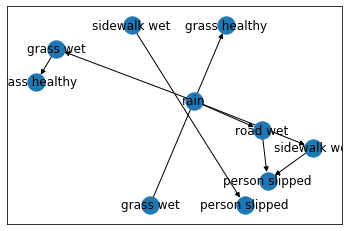

In [28]:
#display graph of each central node and descendants
for cn in centralNodes:
    cn_childgraph = nx.DiGraph()
    cn_childgraph.add_node(cn)
    cn_childgraph = find_node_children_subgraph(DG, cn, cn_childgraph)

In [11]:
nx.graph_edit_distance

<function networkx.algorithms.similarity.graph_edit_distance(G1, G2, node_match=None, edge_match=None, node_subst_cost=None, node_del_cost=None, node_ins_cost=None, edge_subst_cost=None, edge_del_cost=None, edge_ins_cost=None, upper_bound=None)>

# Similarity method: Simrank (Networkx)

In [12]:
for pair in HCNchoose2: 
    simrank = nx.algorithms.similarity.simrank_similarity(DG, source=pair[0], target=pair[1])
    print(pair,  simrank)

('sidewalk wet', 'rain') 0.0
('sidewalk wet', 'grass wet') 0.0
('rain', 'grass wet') 0.0
